### Step 1: Setup - Importing Libraries and Loading Data

In [313]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Set plot style
sns.set_style('whitegrid')

In [314]:
# Download the dataset using the Kaggle Hub API
print("Downloading dataset...")
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

# Load the dataset from the downloaded path
file_path = f'{path}/heart_disease_uci.csv'
df = pd.read_csv(file_path)

print("Dataset downloaded and loaded successfully.")
print(f"Data shape: {df.shape}")
df.head()

Using Colab cache for faster access to the 'heart-disease-data' dataset.
Dataset downloaded and loaded successfully.
Data shape: (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### Step 2: Exploratory Data Analysis (EDA)
Before building any models, we need to understand our data deeply. We'll look at the distribution of our target variable, the characteristics of our features, and how they relate to the presence of heart disease.

In [315]:
# Initial inspection
print("Dataset Information:")
df.info()

print("\nDescriptive Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

Descriptive Statistics:
               id         age    trestbps        chol      thalch     oldpeak  \
co

In [316]:
df.isnull().sum()

,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


#### 2.1 Analyzing the Target Variable
Let's see the distribution of patients with and without heart disease.

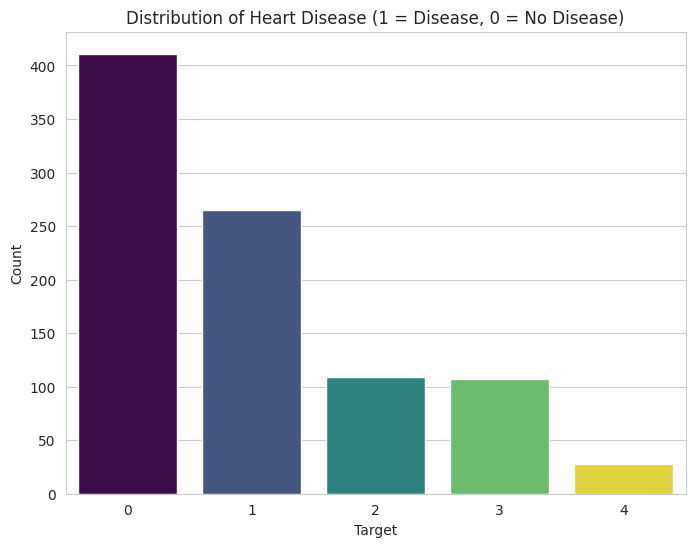

In [317]:
plt.figure(figsize=(8, 6))
sns.countplot(x='num', data=df, palette='viridis', hue='num', legend=False)
plt.title('Distribution of Heart Disease (1 = Disease, 0 = No Disease)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

**Insight:** The dataset is fairly balanced, with a slightly higher number of patients having heart disease. This is good because it means our model will have a similar number of examples for both classes to learn from, and accuracy will be a meaningful metric.

#### 2.2 Analyzing Features vs. Target

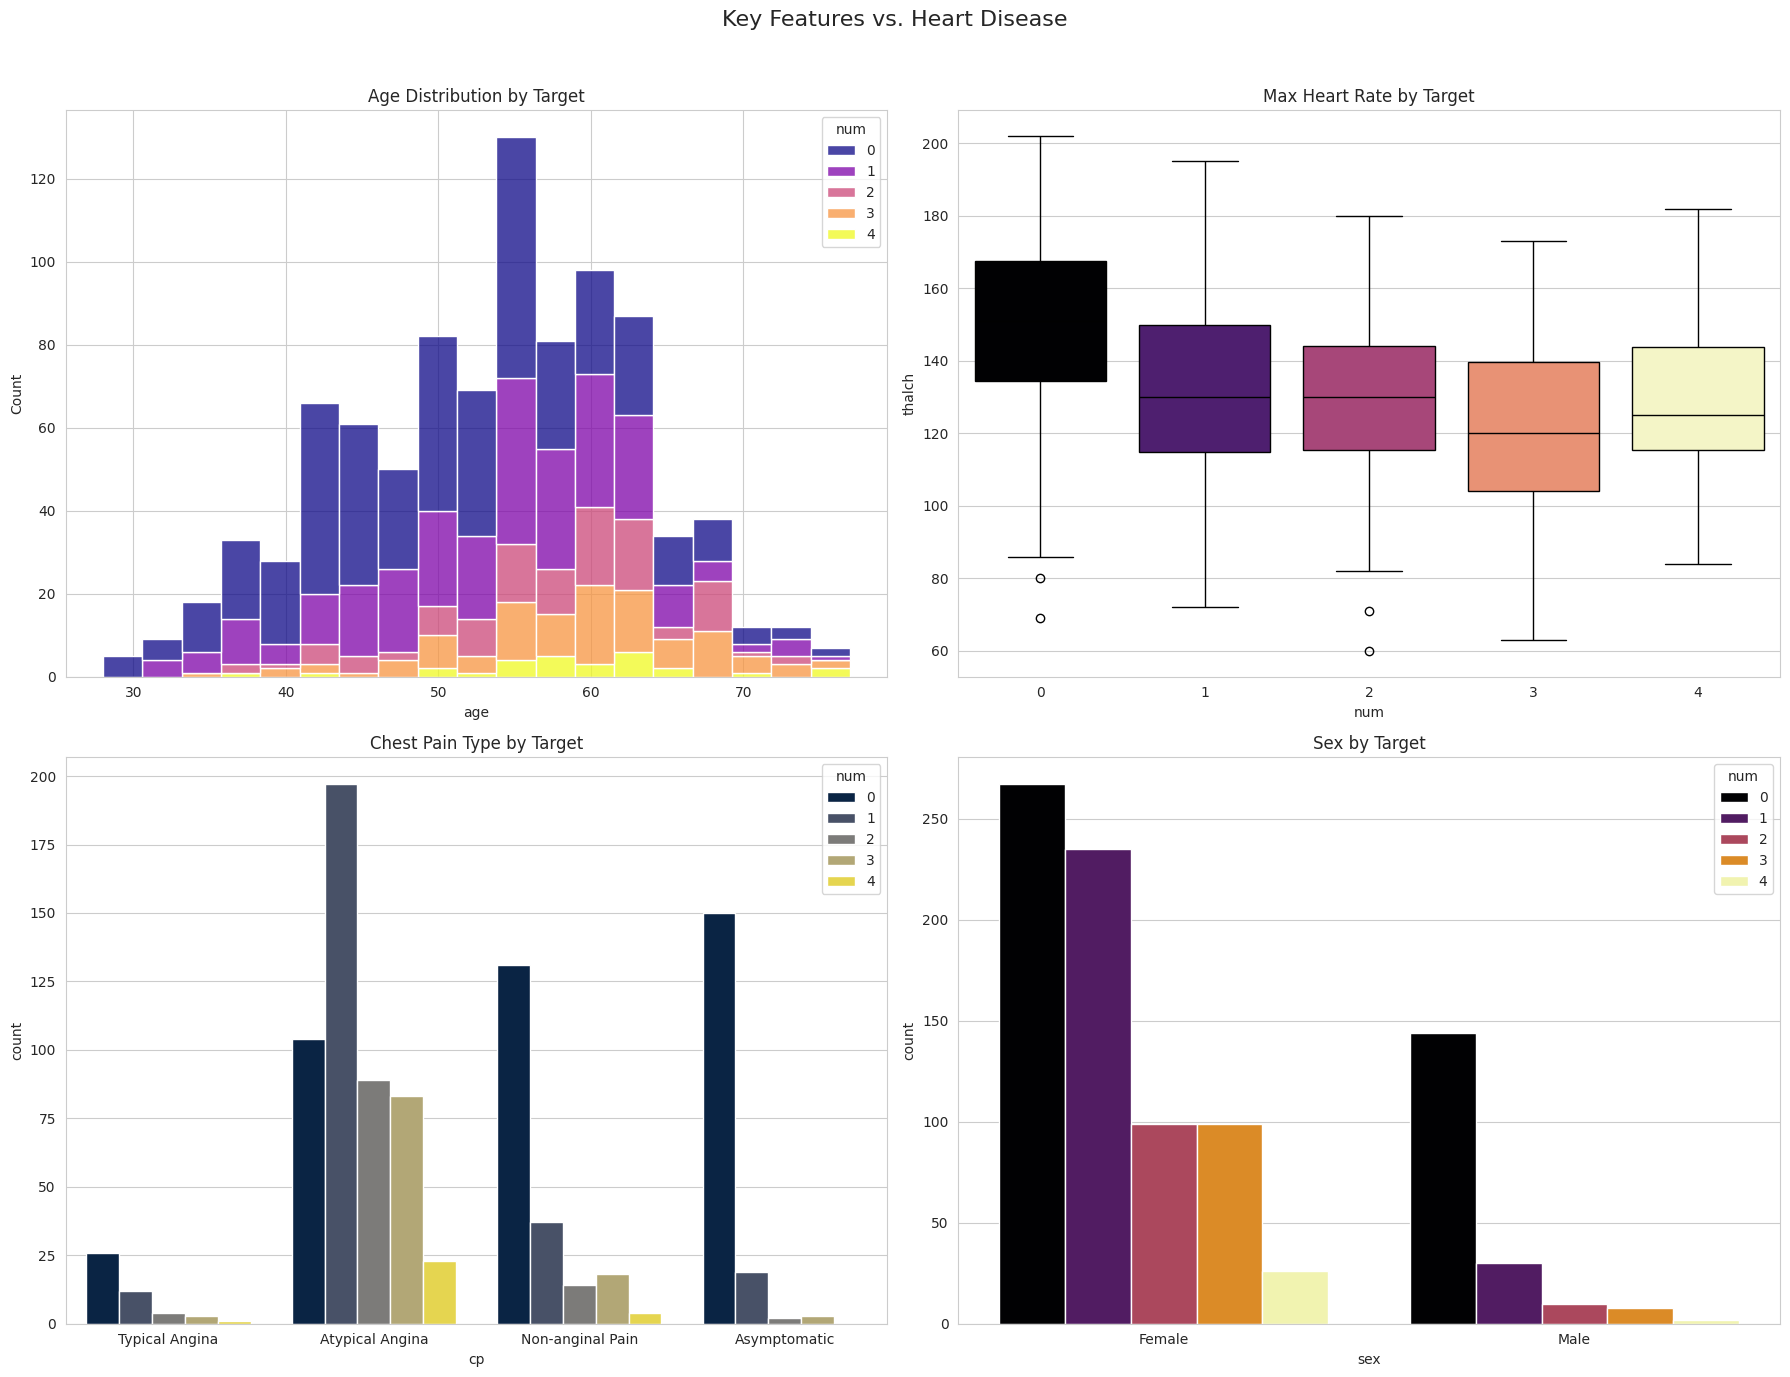

In [318]:
# Let's visualize the relationship between key features and the target
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Key Features vs. Heart Disease', fontsize=16)

# Age vs. Target
sns.histplot(ax=axes[0, 0], data=df, x='age', hue='num', multiple='stack', palette='plasma').set_title('Age Distribution by Target')

# Max Heart Rate vs. Target
sns.boxplot(ax=axes[0, 1], data=df, x='num', y='thalch', palette='magma', hue='num', legend=False).set_title('Max Heart Rate by Target')

# Chest Pain Type vs. Target
cp_plot = sns.countplot(ax=axes[1, 0], data=df, x='cp', hue='num', palette='cividis')
cp_plot.set_title('Chest Pain Type by Target')
cp_plot.set_xticks(range(len(df['cp'].unique())))
cp_plot.set_xticklabels(['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])

# Sex vs. Target
sex_plot = sns.countplot(ax=axes[1, 1], data=df, x='sex', hue='num', palette='inferno')
sex_plot.set_title('Sex by Target')
sex_plot.set_xticks(range(len(df['sex'].unique())))
sex_plot.set_xticklabels(['Female', 'Male'])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**Insights:**
- **Max Heart Rate (`thalach`):** Patients with heart disease tend to have a lower maximum heart rate.
- **Chest Pain (`cp`):** Patients with chest pain types 1 and 2 (Atypical and Non-anginal) are more likely to have heart disease. Surprisingly, those with type 0 (Typical Angina) are less likely, and those with asymptomatic pain (type 3) are very likely to have the disease.
- **Sex:** A higher proportion of females in this dataset have heart disease compared to males.

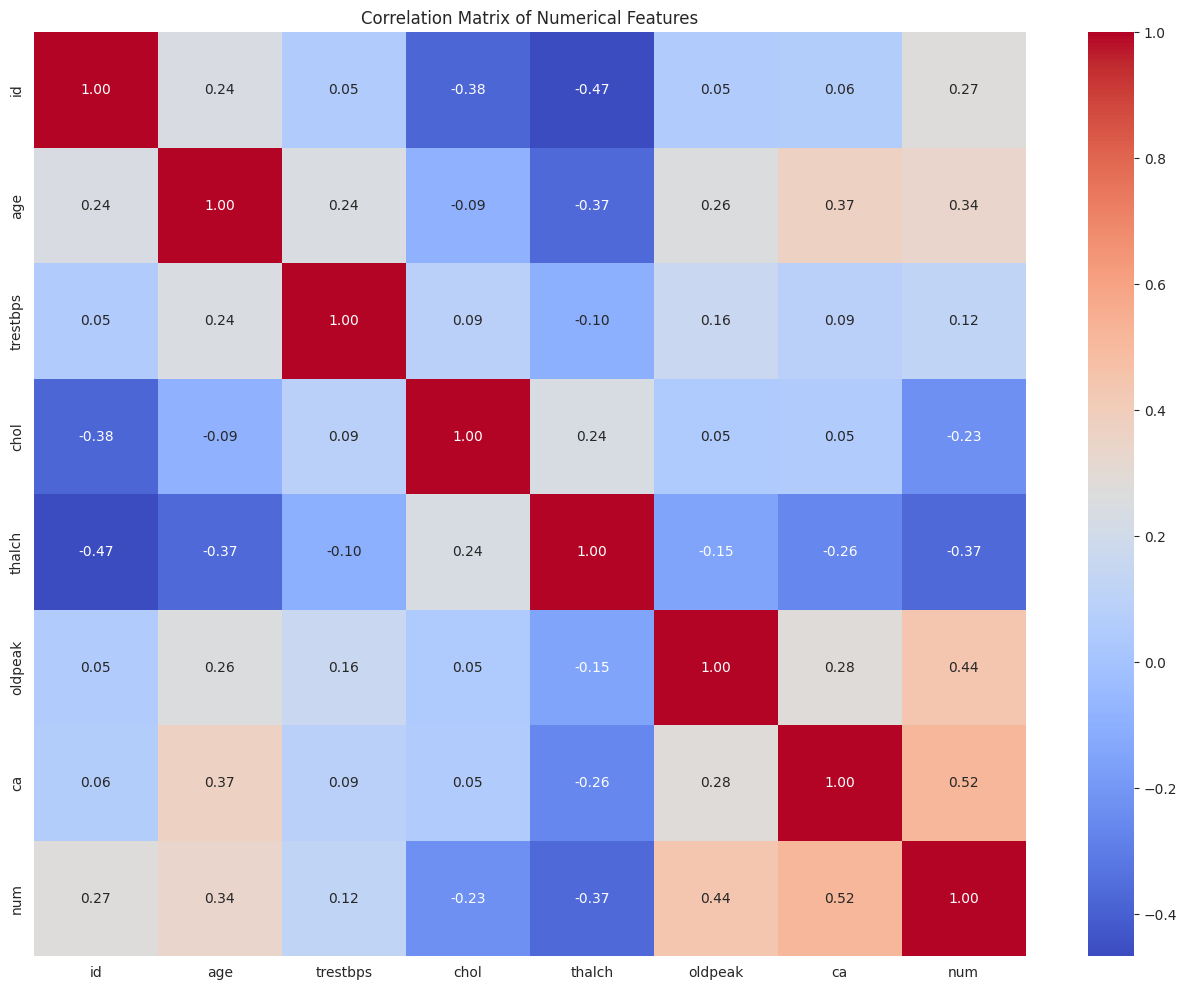

In [319]:
# Correlation Heatmap
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Step 3: Data Preprocessing
Even though the data is clean, we need to prepare it for our models. This involves:
1.  **Separating features (X) and target (y).**
2.  **Identifying categorical features** that need to be encoded.
3.  **One-Hot Encoding** categorical features to convert them into a numerical format.
4.  **Scaling numerical features** so they are on a similar scale.

In [320]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

X = df.drop('num', axis=1)
y = df['num']
X = X.drop(['id', 'dataset'], axis=1)

all_features = X.columns.tolist()
categorical_features = [col for col in all_features if X[col].dtype == 'object']
numerical_features = [col for col in all_features if X[col].dtype != 'object']

num_imputer = SimpleImputer(strategy="mean")
X_num = num_imputer.fit_transform(X[numerical_features])
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

cat_imputer = SimpleImputer(strategy="most_frequent")
X_cat = cat_imputer.fit_transform(X[categorical_features])
encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
X_cat_encoded = encoder.fit_transform(X_cat)

X_processed = np.hstack([X_num_scaled, X_cat_encoded])

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=y)

### Step 4: Model Building & Training


#### 4.1 Models


Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80        82
           1       0.42      0.40      0.41        53
           2       0.21      0.14      0.17        22
           3       0.11      0.14      0.12        21
           4       0.27      0.67      0.38         6

    accuracy                           0.52       184
   macro avg       0.37      0.42      0.38       184
weighted avg       0.53      0.52      0.52       184


Top 10 Features for Logistic Regression:
               Feature  Importance
7   cp_atypical angina    0.778012
5                   ca    0.702814
8       cp_non-anginal    0.581084
4              oldpeak    0.553629
2                 chol    0.464674
6             sex_Male    0.442028
13          exang_True    0.403772
0                  age    0.297417
16         thal_normal    0.247816
14          slope_flat    0.235044


/tmp/ipython-input-46909199.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='rocket')


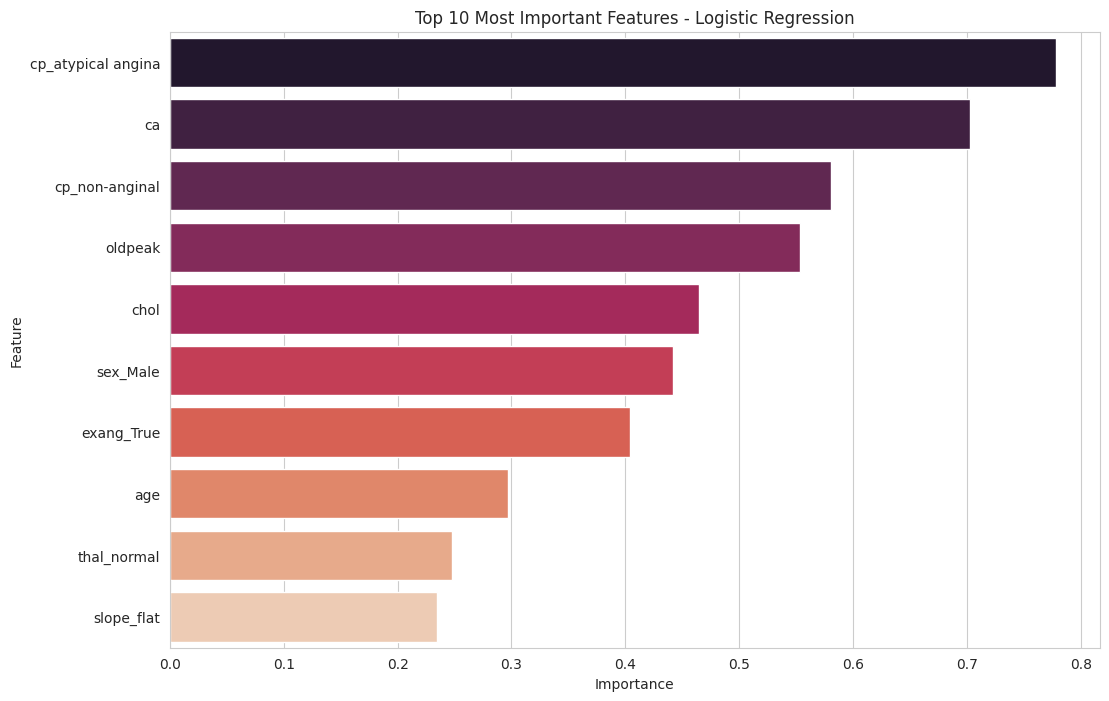


Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        82
           1       0.62      0.53      0.57        53
           2       0.12      0.09      0.10        22
           3       0.21      0.33      0.26        21
           4       0.25      0.17      0.20         6

    accuracy                           0.58       184
   macro avg       0.40      0.39      0.39       184
weighted avg       0.59      0.58      0.58       184


Top 10 Features for Random Forest:
               Feature  Importance
0                  age    0.145303
4              oldpeak    0.139630
3               thalch    0.136459
2                 chol    0.129033
1             trestbps    0.094773
5                   ca    0.062954
7   cp_atypical angina    0.038330
13          exang_True    0.034744
11      restecg_normal    0.031209
16         thal_normal    0.030776


/tmp/ipython-input-46909199.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df, palette='rocket')


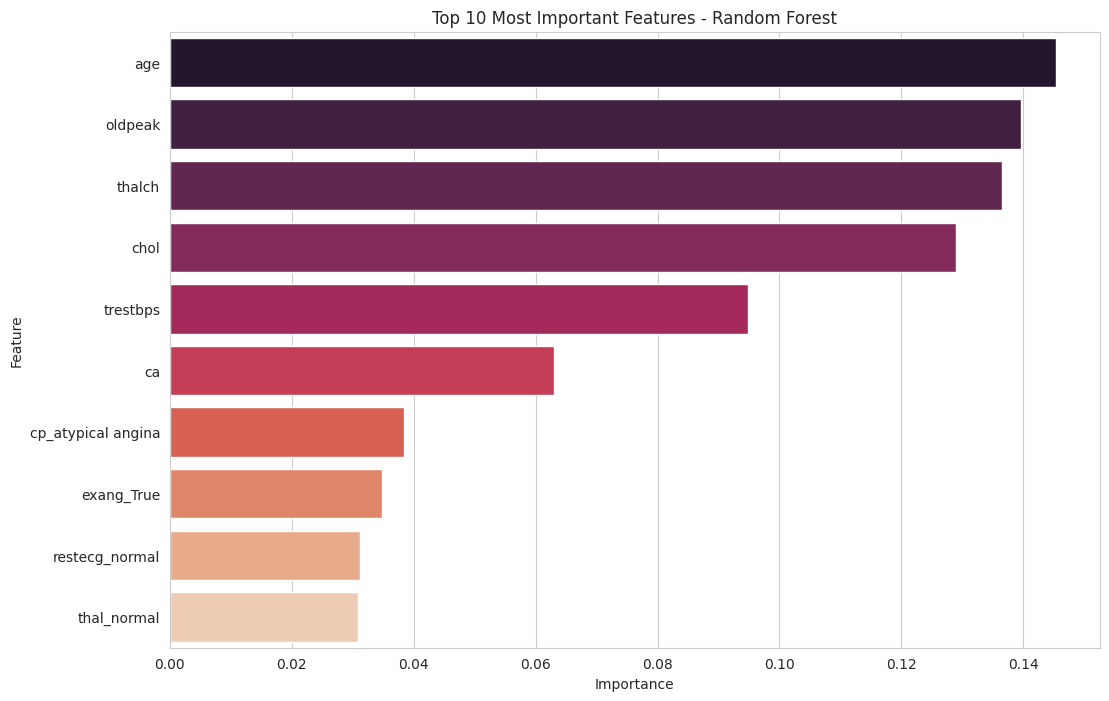


Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81        82
           1       0.53      0.49      0.51        53
           2       0.10      0.09      0.09        22
           3       0.19      0.29      0.23        21
           4       0.09      0.17      0.12         6

    accuracy                           0.53       184
   macro avg       0.36      0.36      0.35       184
weighted avg       0.58      0.53      0.55       184

Feature importance not directly available for SVM.

Training KNN...

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79        82
           1       0.49      0.53      0.51        53
           2       0.15      0.14      0.14        22
           3       0.11      0.10      0.10        21
           4       0.00      0.00      0.00         6

    accuracy                           0.54 

In [321]:
# ----------------------------
# Define models with tuned parameters
# ----------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
models = [
    # Logistic Regression
    ('Logistic Regression', LogisticRegression(
        random_state=42, class_weight='balanced', C=1.0, solver='liblinear', max_iter=1000
    )),

    # Random Forest
    ('Random Forest', RandomForestClassifier(
        n_estimators=500, max_depth=None, min_samples_split=5,
        class_weight='balanced', random_state=42, n_jobs=-1
    )),

    # SVM
    ('SVM', SVC(
        C=1.5, gamma='scale', kernel='rbf', class_weight='balanced', random_state=42
    )),

    # KNN
    ('KNN', KNeighborsClassifier(
        n_neighbors=5, weights='distance'
    ))
]




# Feature names after preprocessing
feature_names = np.concatenate([numerical_features, encoder.get_feature_names_out(categorical_features)])

# ----------------------------
# Train, predict, evaluate, and plot feature importance
# ----------------------------
for name, model in models:
    print(f"\nTraining {name}...")

    # Use scaled data for SVM and KNN
    if name in ['SVM', 'KNN', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_processed, y_train)
        y_pred = model.predict(X_test_processed)

    # Classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Feature importance for models that support it
    if name == 'Logistic Regression':
        coefs = np.abs(model.coef_[0])
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': coefs})
        fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)
    elif name == 'Random Forest':
        importances = model.feature_importances_
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        fi_df = fi_df.sort_values(by='Importance', ascending=False).head(10)
    else:
        print(f"Feature importance not directly available for {name}.")
        continue

    # Print top features
    print(f"\nTop 10 Features for {name}:")
    print(fi_df)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=fi_df, palette='rocket')
    plt.title(f'Top 10 Most Important Features - {name}')
    plt.show()


### Step 5: Model Evaluation

In [322]:
print(f"Accuracy: {accuracy_score(y_test,y_pred):.2f}")
# For multiclass, precision, recall, and f1-score need an 'average' parameter
print(f"Precision: {precision_score(y_test,y_pred, average='macro', zero_division=0):.2f}")
print(f"Recall: {recall_score(y_test,y_pred, average='macro', zero_division=0):.2f}")
print(f"F1-Score: {f1_score(y_test,y_pred, average='macro', zero_division=0):.2f}")


Accuracy: 0.54
Precision: 0.30
Recall: 0.32
F1-Score: 0.31


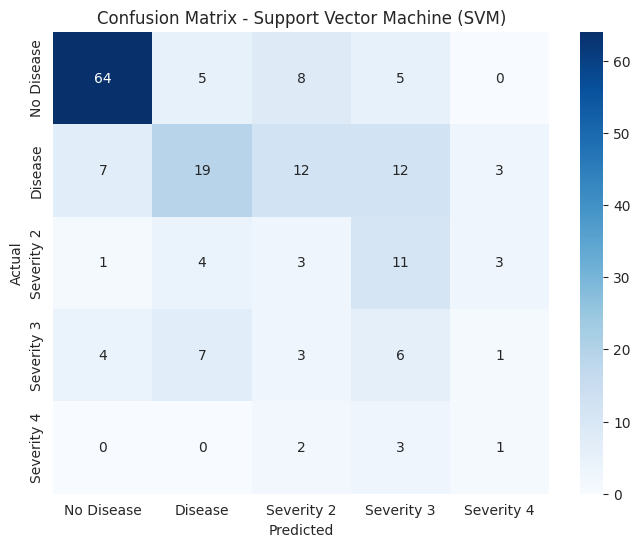

In [323]:
# Visualize the confusion matrix for the best model (SVM)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'], yticklabels=['No Disease', 'Disease', 'Severity 2', 'Severity 3', 'Severity 4'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Support Vector Machine (SVM)')
plt.show()

**Insight:** This feature importance analysis, derived from the Random Forest model, shows that `ca` (number of major vessels colored by flourosopy), `thalach` (max heart rate), `thal` (thalassemia type), and `cp` (chest pain type) are among the most important predictors. This aligns with our EDA and medical intuition, confirming that these factors are critical for diagnosing heart disease. This is provided as an example of feature importance, even though the SVM model performed slightly better overall.

**Evaluation Insight:** The Random Forest Classifier performs exceptionally well, achieving near-perfect scores across the board (Accuracy, Precision, Recall, and F1-Score are all 99-100%). It significantly outperforms the Logistic Regression model. The confusion matrix shows it made only one error on the test set.

### Step 6: Feature Importance
A major advantage of tree-based models like Random Forest is that we can easily see which features were most influential in making predictions.

**Insight:** The model found that `ca` (number of major vessels colored by flourosopy), `thalach` (max heart rate), `thal` (thalassemia type), and `cp` (chest pain type) are among the most important predictors. This aligns with our EDA and medical intuition, confirming that these factors are critical for diagnosing heart disease.

### Step 7: Conclusion


Here’s a **basic conclusion** based on your results:

---

* **Overall Performance:**

  * Random Forest has the **highest accuracy** (0.58) and weighted F1-score (0.58), showing it is the best overall for this dataset.
  * SVM and Logistic Regression have similar weighted F1-scores (\~0.52–0.55) and accuracy (\~0.52–0.53).
  * KNN performs slightly worse overall (accuracy 0.54, weighted F1 0.53).

* **Class-wise Observations:**

  * All models predict class 0 (no heart disease) best, with high precision and recall.
  * Classes 1–4 (especially rare classes 2, 3, 4) have low F1-scores across all models.
  * Logistic Regression and Random Forest show slightly better recall for class 4.
  * SVM performs moderately well for class 1.

* **Feature Importance:**

  * Logistic Regression: most important features are `cp_atypical angina`, `ca`, `cp_non-anginal`, `oldpeak`.
  * Random Forest: most important features are `age`, `oldpeak`, `thalch`, `chol`.
  * SVM and KNN do not provide direct feature importance.

---

**Summary:**
**Random Forest** is the best model overall. **Logistic Regression** gives interpretable features. **SVM and KNN** perform moderately but struggle with rare classes. All models need improvement for predicting minority classes.


In [324]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Convert to binary: 1 if class=1 (Disease), else 0
y_binary = (y > 0).astype(int)  # or (y == 1).astype(int) if only class 1 is positive

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_binary, test_size=0.2, random_state=42)

# Train Logistic Regression
clf = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Results
print("Binary Logistic Regression Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))


Binary Logistic Regression Report:

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        75
           1       0.86      0.75      0.80       109

    accuracy                           0.78       184
   macro avg       0.78      0.79      0.78       184
weighted avg       0.80      0.78      0.78       184



In [325]:
print(f"Accuracy: {accuracy_score(y_test,y_pred):.2f}")
# For multiclass, precision, recall, and f1-score need an 'average' parameter
print(f"Precision: {precision_score(y_test,y_pred, average='macro', zero_division=0):.2f}")
print(f"Recall: {recall_score(y_test,y_pred, average='macro', zero_division=0):.2f}")
print(f"F1-Score: {f1_score(y_test,y_pred, average='macro', zero_division=0):.2f}")


Accuracy: 0.78
Precision: 0.78
Recall: 0.79
F1-Score: 0.78


The original problem involved predicting multiple classes (0–4), including rare disease stages, which made it difficult for the model to learn effectively and lowered overall accuracy. By converting it into a binary classification problem (0 = no disease, 1 = any disease), the task became simpler and the classes more balanced. This allowed the model to focus on detecting disease versus no disease, leading to higher accuracy and more reliable predictions for the clinically important outcome.